# Classifying chat messages

Given a data set of manually labeled chat messages, create a model that can automatically tag new chat messages based on its content.

## Data

The data (shown below) consists of 6869 chat messages, each tagged with one or more tags.

In [1]:
import json
import string

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd

customer_queries = []

with open("anonymous labeled conversations.json", "r") as cq_file:
    for line in cq_file:
        parsed_query = json.loads(line)
        parsed_query["original_message"] = BeautifulSoup(parsed_query["original_message"]).get_text()        
        customer_queries.append(parsed_query)

df = pd.DataFrame(customer_queries)
df

/Users/kevintse/Code/monzobank/virtualenv/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html5lib")

  markup_type=markup_type))


,original_message,tag1,tag2,tag3
0,I was unable to complete an eBay transaction w...,APP - Outage,None,None
1,"Hi, I still haven't received my mondo card and...",CARD - Not Arrived,None,None
2,"Hey, I'm liking the new app design but ever si...",APP - iOS Bug (known),None,None
3,how come i cannot top up more than £100?,KYC - limit driven,None,None
4,I don't recall this transaction,APP - Unrecognized Transaction,None,None
5,Hi - I don't recognise the transaction - appea...,APP - Unrecognized Transaction,None,None
6,Hey,TOP UP - Bank transfer,None,None
7,"Hey guys, I'm wondering if I haven't passed th...",KYC - limit driven,None,None
8,Hello,CARD - Not Arrived,None,None
9,"I'm running the latest beta of iOS 10, on an i...",APP - iOS Bug (known),None,None


## The Model

Building off of the bag-of-words model suggested in the assignment, I used tf-idf and SVMs to predict the label of the chat message (specifically the tag1 field). Most of this code was adapted from scikit-learn's Working with Text page. 

The model was evaluated using 5-fold cross-validation. Assume you cut the data set into 5 equal chunks. You train your model on 4 chunks (the “training set”) and evaluate its performance on the 1 chunk left out (the “validation set”). You then re-train your model on the other four combinations of training and validation sets and assess its performance over the five iterations. This prevents the model from “cheating” by testing its performance on data it has trained on already.

The output shows two tables. The first is the precision/recall table on the **last** iteration. This gives a good look into the performance of the model.

The second table is the confusion matrix. The columns represent the predicted labels while the rows represent the actual labels. This provides more granularity into what the model got right and wrong.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt

from IPython.display import display

count_vectorizer = CountVectorizer()

text_clf = Pipeline([('vect', count_vectorizer),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2')),
])

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(df['original_message']):
    train_X = df['original_message'].ix[train_index].values
    train_Y = df['tag1'].ix[train_index].values
    labels = df['tag1'].unique()
    test_X = df['original_message'].ix[test_index].values
    test_Y = df['tag1'].ix[test_index].values
        
    text_clf = text_clf.fit(train_X, train_Y)
    predicted_Y = text_clf.predict(test_X)
print(metrics.classification_report(test_Y, predicted_Y))
conf = pd.DataFrame(metrics.confusion_matrix(test_Y, predicted_Y, labels=labels), index=labels)
conf.columns = labels
display(conf)

                                precision    recall  f1-score   support

                  APP - Outage       0.56      0.37      0.44        65
APP - Unrecognized Transaction       0.83      0.71      0.77        80
         APP - iOS Bug (known)       0.80      0.81      0.81        91
            CARD - Not Arrived       0.92      0.94      0.93       154
         DECLINE - Contactless       0.81      0.81      0.81        64
            KYC - limit driven       0.89      0.88      0.88       161
      ONBOARDING - £100 amount       0.62      0.53      0.57        15
              PAYMENT - REFUND       0.84      0.84      0.84        96
                    PIN - sent       0.96      0.99      0.97       394
        TOP UP - Bank transfer       0.84      0.86      0.85       112
             TRAVEL - FX rates       0.80      0.92      0.86        64
TRAVEL - TfL transaction query       0.79      0.87      0.83        77

                   avg / total       0.86      0.87      0.86 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,24,1,7,4,1,3,7,1,3,4,9,1
CARD - Not Arrived,0,144,0,0,1,0,0,1,6,1,0,1
APP - iOS Bug (known),4,4,74,2,0,2,0,0,0,2,1,2
KYC - limit driven,4,0,1,141,2,7,0,3,2,0,1,0
APP - Unrecognized Transaction,0,2,4,2,57,2,6,3,0,4,0,0
TOP UP - Bank transfer,1,0,2,6,1,96,1,2,2,1,0,0
TRAVEL - TfL transaction query,2,1,1,0,3,0,67,1,1,0,1,0
TRAVEL - FX rates,0,0,1,0,0,0,1,59,2,1,0,0
PIN - sent,0,1,0,1,0,0,0,2,390,0,0,0
PAYMENT - REFUND,1,3,2,0,3,4,1,0,0,81,0,1


# Questions

## How would you evaluate the model results? Which metrics would you use to judge whether your model is “good” or “bad”. Tip: there is tradeoff to be made.
	
I evaluated the model’s performance by checking its precision and recall on specific tags and the dataset as a whole. Assume that in the data set, 10 chat messages were tagged with the label X. Assume that the model predicted 6 messages to have a label of X, but only 4 of those were actually X (true positives). Precision measures how many chat messages the model tagged as X were actually X (4/6) and is an indication of quality, while recall measures how many X messages did the model tag (4/10) and is an indication of completeness. 

There is an inherent trade-off to both precision and recall. You can increase precision by decreasing the amount of messages the model tags as X, but that penalizes recall. Conversely, you can increase recall by tagging more messages as X, but the results will be less relevant and therefore less precise. 

Although my model had more or less the same precision and recall across the dataset as a whole, individual labels would have wildly varying precision and recall, from heavily weighting recall for “TRAVEL - FX rates” messages to heavily weighting precision for “APP – Outage” messages. Given the precision-recall trade-off, I would weight precision more for the simple reason that to build trust in the model, it is better to tag fewer messages correctly than it is to make sure you tagged all relevant messages.
    
## Given it’s a very simple model, do you see a way how it still might be useful? Maybe in parts? Are the resulting class probabilities useful in some way?

If you only looked at the F-score (the harmonic mean of recall and precision) to evaluate what tags the model is useful for, it’s clear that the model is only useful for certain tags. For example, with an F-score of 0.91, I would trust the model to correctly tag a message with “PIN - sent”. I would have less trust in the model when it tags a message with “APP – Outage”.

## Can you think of any potential issues with relying on such models?

* Data quality: The model is only as good as the data you give it. If you give it very noisy data, such as those tagged as "APP – Outage" (Appendix C), its performance will suffer.
* Interpretability: It's difficult to explain to a layman why a model tagged a chat message a certain way. Depending on the context, interpretability may be crucial to adoption of a model.
    
## How can this model be further improved?

In Appendix B I've shown failed attempts to improve the model, namely centered around better data pre-processing such as:

* stripping out numbers
* stemming words to reduce the vocabulary
* SVM parameter optimization

Some possible areas to explore include:

* Adding more features, such as user's phone operating system, time at which the chat message was sent, outage information during that time, etc. This is hinted at by the plateauing performance of the model as shown in Appendix A.
* Switching algorithms (i.e. LSTM, word2vec)
	
## Imagine we would have granular enough labels and a corresponding standard answer that fits to every label. Would we be able to use your model to automate our chat replies or make them more efficient? 

Only for tags that the model has a high F-score for. I would hesitate to use it for all labels due to its inconsistent performance. 

# Appendix A

## Learning Curves

To verify whether the model would benefit from more data samples, I adapted scikit-learn's script to plot the model's learning curve. The model's performance on the validation set slowly plateaus, indicating that more data samples may not help the model as much.

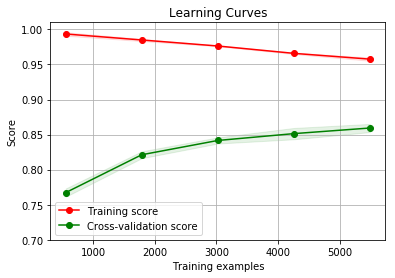

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = df['original_message'], df['tag1']

title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = text_clf
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

## Appendix B

This represents a more sophisticated strategy in cleaning the original messages before plugging it into the model. This did not improve precision or recall in a noticeable way.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer

from IPython.display import display

stemmer = SnowballStemmer("english")


def strip_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def strip_stopwords(words_list):
    return [word for word in words_list if word not in stopwords.words("english")]

def strip_numbers(text):
    translator = str.maketrans('', '', string.digits)
    return text.translate(translator)

def stem_words(words_list):
    return [stemmer.stem(word) for word in words_list]

def preprocess_message(text):
    text = text.lower()
    text = strip_punctuation(text)
    text = strip_numbers(text)
    words_list = text.split()
    words_list = strip_stopwords(words_list)
    words_list = stem_words(words_list)
    text = " ".join(words_list)
    return text

count_vectorizer = CountVectorizer(preprocessor=preprocess_message)

text_clf = Pipeline([('vect', count_vectorizer),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2')),
])

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(df['original_message']):
    train_X = df['original_message'].ix[train_index].values
    train_Y = df['tag1'].ix[train_index].values
    labels = df['tag1'].unique()
    test_X = df['original_message'].ix[test_index].values
    test_Y = df['tag1'].ix[test_index].values
        
    text_clf = text_clf.fit(train_X, train_Y)
    predicted_Y = text_clf.predict(test_X)
    print(metrics.classification_report(test_Y, predicted_Y))
    conf = pd.DataFrame(metrics.confusion_matrix(test_Y, predicted_Y, labels=labels), index=labels)
    conf.columns = labels
    display(conf)

                                precision    recall  f1-score   support

                  APP - Outage       0.60      0.47      0.52        92
APP - Unrecognized Transaction       0.70      0.72      0.71        79
         APP - iOS Bug (known)       0.80      0.76      0.78        96
            CARD - Not Arrived       0.84      0.94      0.89       161
         DECLINE - Contactless       0.77      0.75      0.76        59
            KYC - limit driven       0.89      0.88      0.88       141
      ONBOARDING - £100 amount       0.55      0.40      0.46        15
              PAYMENT - REFUND       0.85      0.78      0.81        99
                    PIN - sent       0.97      0.97      0.97       354
        TOP UP - Bank transfer       0.77      0.86      0.81       131
             TRAVEL - FX rates       0.76      0.90      0.83        72
TRAVEL - TfL transaction query       0.84      0.72      0.78        75

                   avg / total       0.84      0.84      0.84 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,43,4,8,3,4,4,5,4,3,5,9,0
CARD - Not Arrived,1,152,0,1,0,1,0,2,2,1,0,1
APP - iOS Bug (known),4,3,73,3,2,5,0,1,0,3,1,1
KYC - limit driven,4,1,1,124,1,7,0,1,1,0,1,0
APP - Unrecognized Transaction,1,2,2,0,57,5,3,2,2,4,1,0
TOP UP - Bank transfer,0,4,1,4,3,113,0,2,0,1,0,3
TRAVEL - TfL transaction query,3,3,3,0,6,2,54,3,0,0,1,0
TRAVEL - FX rates,0,4,0,1,0,1,0,65,1,0,0,0
PIN - sent,2,4,1,0,0,0,0,3,344,0,0,0
PAYMENT - REFUND,1,2,0,1,8,5,2,2,1,77,0,0


                                precision    recall  f1-score   support

                  APP - Outage       0.55      0.35      0.43        74
APP - Unrecognized Transaction       0.71      0.79      0.75        73
         APP - iOS Bug (known)       0.71      0.85      0.77        73
            CARD - Not Arrived       0.86      0.95      0.90       132
         DECLINE - Contactless       0.90      0.88      0.89        68
            KYC - limit driven       0.77      0.80      0.79       156
      ONBOARDING - £100 amount       0.80      0.15      0.26        26
              PAYMENT - REFUND       0.83      0.87      0.85       107
                    PIN - sent       0.97      0.99      0.98       380
        TOP UP - Bank transfer       0.83      0.76      0.79       136
             TRAVEL - FX rates       0.75      0.82      0.79        67
TRAVEL - TfL transaction query       0.87      0.83      0.85        82

                   avg / total       0.84      0.84      0.83 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,26,2,9,12,3,3,4,2,1,6,6,0
CARD - Not Arrived,0,125,1,0,1,1,1,1,2,0,0,0
APP - iOS Bug (known),0,2,62,1,0,2,1,1,2,1,0,1
KYC - limit driven,9,4,4,125,0,7,1,4,2,0,0,0
APP - Unrecognized Transaction,0,2,0,1,58,1,2,2,1,5,1,0
TOP UP - Bank transfer,3,4,3,10,3,104,0,4,1,4,0,0
TRAVEL - TfL transaction query,1,1,2,0,6,1,68,1,0,2,0,0
TRAVEL - FX rates,2,0,0,5,4,0,0,55,1,0,0,0
PIN - sent,0,0,2,0,1,0,0,1,376,0,0,0
PAYMENT - REFUND,2,0,2,3,5,1,0,1,0,93,0,0


                                precision    recall  f1-score   support

                  APP - Outage       0.60      0.34      0.43        73
APP - Unrecognized Transaction       0.71      0.85      0.77        80
         APP - iOS Bug (known)       0.76      0.80      0.78       109
            CARD - Not Arrived       0.90      0.92      0.91       154
         DECLINE - Contactless       0.73      0.93      0.82        61
            KYC - limit driven       0.78      0.77      0.77       136
      ONBOARDING - £100 amount       0.60      0.26      0.36        23
              PAYMENT - REFUND       0.87      0.85      0.86       118
                    PIN - sent       0.97      0.97      0.97       363
        TOP UP - Bank transfer       0.71      0.86      0.78       103
             TRAVEL - FX rates       0.89      0.88      0.88        80
TRAVEL - TfL transaction query       0.87      0.72      0.79        74

                   avg / total       0.84      0.84      0.83 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,25,0,9,6,5,3,3,2,4,4,11,1
CARD - Not Arrived,0,141,4,0,3,4,0,1,0,1,0,0
APP - iOS Bug (known),3,2,87,5,0,3,2,0,0,4,3,0
KYC - limit driven,3,1,3,105,1,14,0,2,1,0,4,2
APP - Unrecognized Transaction,0,0,2,2,68,1,2,1,1,3,0,0
TOP UP - Bank transfer,0,3,2,3,1,89,0,1,1,1,1,1
TRAVEL - TfL transaction query,5,1,2,3,6,0,53,2,0,2,0,0
TRAVEL - FX rates,0,1,1,5,2,0,0,70,1,0,0,0
PIN - sent,1,1,1,2,4,2,0,0,351,0,1,0
PAYMENT - REFUND,2,1,0,1,5,7,1,0,0,100,1,0


                                precision    recall  f1-score   support

                  APP - Outage       0.56      0.34      0.43        64
APP - Unrecognized Transaction       0.67      0.76      0.71        66
         APP - iOS Bug (known)       0.80      0.82      0.81       105
            CARD - Not Arrived       0.83      0.94      0.88       155
         DECLINE - Contactless       0.78      0.79      0.78        57
            KYC - limit driven       0.89      0.80      0.84       148
      ONBOARDING - £100 amount       0.55      0.33      0.41        18
              PAYMENT - REFUND       0.88      0.87      0.88       105
                    PIN - sent       0.97      0.97      0.97       373
        TOP UP - Bank transfer       0.82      0.85      0.83       131
             TRAVEL - FX rates       0.76      0.90      0.82        77
TRAVEL - TfL transaction query       0.78      0.76      0.77        75

                   avg / total       0.84      0.84      0.84 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,22,6,7,3,5,3,4,0,3,2,8,1
CARD - Not Arrived,0,146,0,0,2,1,0,1,1,3,0,1
APP - iOS Bug (known),2,2,86,2,2,0,2,4,2,1,2,0
KYC - limit driven,5,2,4,118,2,9,2,4,2,0,0,0
APP - Unrecognized Transaction,0,4,2,1,50,2,2,2,1,1,1,0
TOP UP - Bank transfer,1,5,3,1,1,111,1,3,2,3,0,0
TRAVEL - TfL transaction query,2,1,1,1,8,2,57,2,0,0,1,0
TRAVEL - FX rates,0,1,1,1,2,2,1,69,0,0,0,0
PIN - sent,1,4,1,0,2,1,1,1,360,0,1,1
PAYMENT - REFUND,0,2,2,1,0,2,3,2,1,91,0,1


                                precision    recall  f1-score   support

                  APP - Outage       0.42      0.42      0.42        65
APP - Unrecognized Transaction       0.81      0.76      0.79        80
         APP - iOS Bug (known)       0.85      0.84      0.84        91
            CARD - Not Arrived       0.90      0.95      0.92       154
         DECLINE - Contactless       0.91      0.78      0.84        64
            KYC - limit driven       0.86      0.86      0.86       161
      ONBOARDING - £100 amount       0.44      0.27      0.33        15
              PAYMENT - REFUND       0.83      0.89      0.86        96
                    PIN - sent       0.98      0.98      0.98       394
        TOP UP - Bank transfer       0.82      0.79      0.81       112
             TRAVEL - FX rates       0.84      0.88      0.85        64
TRAVEL - TfL transaction query       0.78      0.90      0.83        77

                   avg / total       0.86      0.86      0.86 

,APP - Outage,CARD - Not Arrived,APP - iOS Bug (known),KYC - limit driven,APP - Unrecognized Transaction,TOP UP - Bank transfer,TRAVEL - TfL transaction query,TRAVEL - FX rates,PIN - sent,PAYMENT - REFUND,DECLINE - Contactless,ONBOARDING - £100 amount
APP - Outage,27,0,7,7,1,2,8,1,4,2,5,1
CARD - Not Arrived,2,146,1,0,0,0,2,0,0,1,0,2
APP - iOS Bug (known),3,2,76,4,0,2,0,0,0,3,0,1
KYC - limit driven,9,0,0,138,1,7,1,3,1,1,0,0
APP - Unrecognized Transaction,1,2,4,1,61,3,5,1,0,2,0,0
TOP UP - Bank transfer,4,1,0,7,3,89,1,3,0,3,0,1
TRAVEL - TfL transaction query,4,1,0,0,2,0,69,0,0,1,0,0
TRAVEL - FX rates,1,2,0,0,2,0,1,56,1,1,0,0
PIN - sent,1,2,0,1,1,1,1,1,386,0,0,0
PAYMENT - REFUND,2,2,0,0,2,4,1,0,0,85,0,0


## Appendix C

This represents all messages manually tagged with APP - Outage. As you can see, the chat messages often highlight other problems besides the outage, making the model's job a lot harder.

In [6]:
df[df['tag1'] == 'APP - Outage']

,original_message,tag1,tag2,tag3
0,I was unable to complete an eBay transaction w...,APP - Outage,None,None
24,Hi there! Hoping you can help- I've just had m...,APP - Outage,None,None
27,"Morning, just tried to use my card in Pret but...",APP - Outage,None,None
28,Just had my card not work 3 times at the train...,APP - Outage,None,None
29,"Hi, my card was just declined. Funds are fine ...",APP - Outage,None,None
30,Hi. Card just declined at the railway station ...,APP - Outage,None,None
32,Hi\n\nI tried to use my monzo card this mornin...,APP - Outage,None,None
34,Hi. My card was declined this morning. I looke...,APP - Outage,None,None
36,Have you sorted the payment issue?,APP - Outage,None,None
37,"Hiya, my card was just declined twice in a Sai...",APP - Outage,None,None
